In [1]:
import pandas as pd
import os
import numpy as np
import sklearn
import dataFuncs
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Initialise repositories
_projroot = os.path.abspath('.')
_datadir = os.path.join(_projroot,'data')
_preprocesseddir = os.path.join(_datadir,'preprocesseddata')
_testdir = os.path.join(_datadir,'testdata')
_rawdir = os.path.join(_datadir,'rawdata')
_imagesdir = os.path.join(_projroot,'images')
_overunderdir = os.path.join(_imagesdir,'overunder')

In [2]:
WCC_Survey = pd.read_csv(os.path.join(_preprocesseddir,'WCC_Survey_compress.csv'))
WCC_Survey = WCC_Survey.drop('Unnamed: 0', axis = 1)
WCC_Survey = WCC_Survey.drop('OutputArea', axis=1)

In [3]:
from sklearn.model_selection import train_test_split

target = ["Target"]
features = list(set(list(WCC_Survey.columns))-set(target))

#Normalise continuous features
cont = list(set(WCC_Survey.select_dtypes(exclude=['object'])))
WCC_Survey[cont] = WCC_Survey[cont]/WCC_Survey[cont].max()

X = WCC_Survey[features].values
X_cont = WCC_Survey[features].select_dtypes(include=['float64','int']).fillna(0).values
y = WCC_Survey[target].values

X_train, X_test, y_train, y_test = train_test_split(X_cont, y, test_size=0.30, random_state=0)

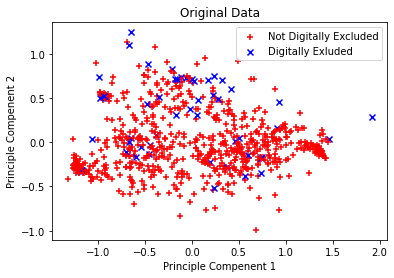

Training dataset shape Counter({0.0: 673, 1.0: 53})


In [4]:
#For visualisation perform PCA to find principle components to plot
from sklearn.decomposition import PCA
import pylab as pl
def plot_this(X_rs,y_rs,method,figname):
  # Use principal component to condense the 10 features to 2 features
  pca = PCA(n_components=2).fit(X_rs)
  pca_2d = pca.transform(X_rs)
  # Assign colors
  for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='x')  
    
  pl.legend([c1, c2], ['Not Digitally Excluded', 'Digitally Exluded'])
  pl.xlabel('Principle Compenent 1')
  pl.ylabel('Principle Compenent 2')
  pl.title(method)
  pl.savefig(os.path.join(_overunderdir, figname), dpi = 1000)
  #pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
  pl.show()
    
plot_this(X_train,y_train,'Original Data','OriginalDataPCA')
#print('Original dataset shape {}'.format(Counter(y)))
print('Training dataset shape {}'.format(Counter(y_train.ravel())))



TomekLinks undersampling Counter({0.0: 659, 1.0: 53})


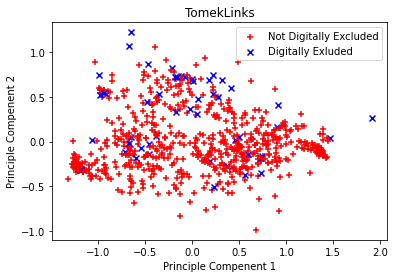

In [5]:
from imblearn.under_sampling import TomekLinks

sampler = TomekLinks() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('TomekLinks undersampling {}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'TomekLinks','TomekLinks')

NearMissCounter({0.0: 53, 1.0: 53})


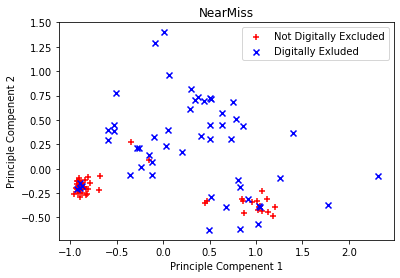

In [6]:
from imblearn.under_sampling import NearMiss

sampler = NearMiss() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('NearMiss{}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'NearMiss','NearMiss')

Cluster centriods undersampling Counter({0.0: 424, 1.0: 53})


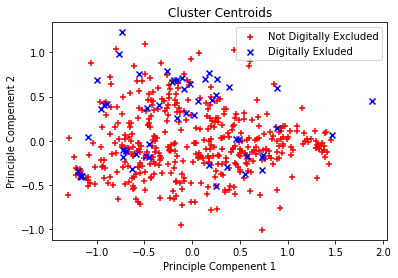

In [7]:
from imblearn.under_sampling import ClusterCentroids

sampler = ClusterCentroids(sampling_strategy=0.125)
X_CC, y_CC = sampler.fit_resample(X_train, y_train)
print('Cluster centriods undersampling {}'.format(Counter(y_CC)))
plot_this(X_CC,y_CC,'Cluster Centroids','ClusterCentroids')

SMOTE Oversampling Counter({0.0: 424, 1.0: 106})


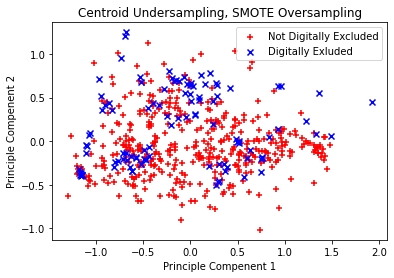

In [8]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy=0.25)
X_rs, y_rs = sampler.fit_resample(X_CC, y_CC)
print('SMOTE Oversampling {}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'Centroid Undersampling, SMOTE Oversampling','CentroidSMOTE')

SMOTE Oversampling Counter({0.0: 673, 1.0: 168})


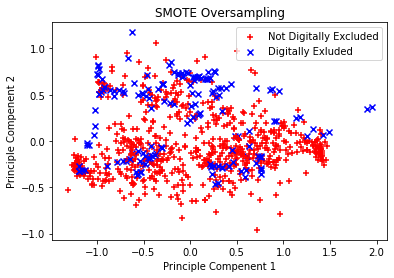

In [9]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy=0.25)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('SMOTE Oversampling {}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'SMOTE Oversampling','SMOTE')

NearestNeighbours Clearning Rule undersampling Counter({0.0: 570, 1.0: 53})


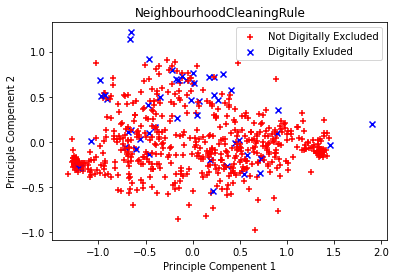

In [10]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

sampler = NeighbourhoodCleaningRule() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('NearestNeighbours Clearning Rule undersampling {}'.format(Counter(y_rs)))
plot_this(X_rs,y_rs,'NeighbourhoodCleaningRule','NeighbourhoodCleaningRule')

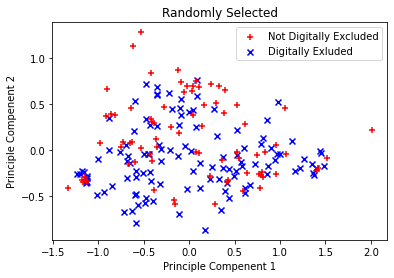

In [11]:
#Create random rows to pull from majority data
from sklearn.model_selection import train_test_split
class1 = []
class2 = []
for i in range(0,len(y_rs.ravel())):
    if y_rs[i] == 0:
        class1.append(i)
    else:
        class2.append(i)

#print(class1)
import random
X_class1 = X_rs[class1,:]
y_class1 = np.ones(116)
X_class2 = X_rs[class2,:]
y_class2 = np.zeros(116)


Xa,Xb = train_test_split(X_class1, test_size = 0.5)

X1,X2 = train_test_split(Xa, test_size = 0.5)
X3,X4 = train_test_split(Xb, test_size = 0.5)

X1 = np.append(X1,X_class2, axis = 0)
X2 = np.append(X2,X_class2, axis = 0)
X3 = np.append(X3,X_class2, axis = 0)
X4 = np.append(X4,X_class2, axis = 0)
y_reduced = np.append(y_class1,y_class2)


plot_this(X1,y_reduced,'Randomly Selected','RandomSelection')

In [13]:
#Create train test aplit in all data and apply pver/undersampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(X_train.shape)


#Undersample dataset with Cluster Centroids
from imblearn.under_sampling import ClusterCentroids
sampler = ClusterCentroids(sampling_strategy=0.125)
X_CC, y_CC = sampler.fit_resample(X_train, y_train)
#Oversample Dataset with SMOTE
from imblearn.over_sampling import SMOTE
sampler = SMOTE(sampling_strategy=0.25)
X_rs, y_rs = sampler.fit_resample(X_CC, y_CC)
#Randomly divide dataset into 4 and save
class1 = []
class2 = []
for i in range(0,len(y_rs.ravel())):
    if y_rs[i] == 0:
        class1.append(i)
    else:
        class2.append(i)
X_class1 = X_rs[class1,:]
y_class1 = np.ones(len(class2))
X_class2 = X_rs[class2,:]
y_class2 = np.zeros(len(class2))


Xa,Xb = train_test_split(X_class1, test_size = 0.5)

X1,X2 = train_test_split(Xa, test_size = 0.5)
X3,X4 = train_test_split(Xb, test_size = 0.5)

x1_tot = np.append(X1, X_class2, axis = 0)
print(np.shape(x1_tot))
data1_tot = np.append(y_class1, y_class2, axis = 0)
data1_tot = np.append(data1_tot, x1_tot, axis = 1)



df1 = pd.dataframe(data = data1_tot, columns = WCC_Survey.columns)

(726, 39)


ValueError: could not convert string to float: 'None of these'